In [4]:
!wget https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/Adenovirus/geography_types/Nation/geographies/England/metrics/adenovirus_testing_positivityByWeek


--2024-11-28 22:06:33--  https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/Adenovirus/geography_types/Nation/geographies/England/metrics/adenovirus_testing_positivityByWeek
Resolving api.ukhsa-dashboard.data.gov.uk (api.ukhsa-dashboard.data.gov.uk)... 108.138.217.42, 108.138.217.58, 108.138.217.88, ...
Connecting to api.ukhsa-dashboard.data.gov.uk (api.ukhsa-dashboard.data.gov.uk)|108.138.217.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2156 (2.1K) [application/json]
Saving to: ‘adenovirus_testing_positivityByWeek.4’

adenovirus_testing_ 100%[===================>]   2.11K  --.-KB/s    in 0s      

2024-11-28 22:06:33 (327 MB/s) - ‘adenovirus_testing_positivityByWeek.4’ saved [2156/2156]



In [5]:
# Will only work on the JHub or Unix-like systems;
# displays the contents of the file
!cat adenovirus_testing_positivityByWeek


{"count":2695,"next":"https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/Adenovirus/geography_types/Nation/geographies/England/metrics/adenovirus_testing_positivityByWeek?page=2","previous":null,"results":[{"theme":"infectious_disease","sub_theme":"respiratory","topic":"Adenovirus","geography_type":"Nation","geography":"England","geography_code":"E92000001","metric":"adenovirus_testing_positivityByWeek","metric_group":"testing","stratum":"default","sex":"all","age":"45-64","year":2017,"month":7,"epiweek":27,"date":"2017-07-03","metric_value":3.24,"in_reporting_delay_period":false},{"theme":"infectious_disease","sub_theme":"respiratory","topic":"Adenovirus","geography_type":"Nation","geography":"England","geography_code":"E92000001","metric":"adenovirus_testing_positivityByWeek","metric_group":"testing","stratum":"default","sex":"all","age":"65-79","year":2017,"month":7,"epiweek":27,"date":"2017-07-03","metric_value":2.31,"in_reporting_delay_

In [6]:
#Request for API access
import requests

# Same as the above but in Python, with a couple of extra parameters added to the URL
requests.get("https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/Adenovirus/geography_types/Nation/geographies/England/metrics/adenovirus_testing_positivityByWeek").json()


{'count': 2702,
 'next': 'https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/Adenovirus/geography_types/Nation/geographies/England/metrics/adenovirus_testing_positivityByWeek?page=2',
 'previous': None,
 'results': [{'theme': 'infectious_disease',
   'sub_theme': 'respiratory',
   'topic': 'Adenovirus',
   'geography_type': 'Nation',
   'geography': 'England',
   'geography_code': 'E92000001',
   'metric': 'adenovirus_testing_positivityByWeek',
   'metric_group': 'testing',
   'stratum': 'default',
   'sex': 'all',
   'age': '80+',
   'year': 2017,
   'month': 7,
   'epiweek': 27,
   'date': '2017-07-03',
   'metric_value': 0.0,
   'in_reporting_delay_period': False},
  {'theme': 'infectious_disease',
   'sub_theme': 'respiratory',
   'topic': 'Adenovirus',
   'geography_type': 'Nation',
   'geography': 'England',
   'geography_code': 'E92000001',
   'metric': 'adenovirus_testing_positivityByWeek',
   'metric_group': 'testing',
   'stratum':

In [7]:
import requests
import time

class APIwrapper:
    # class variables shared among all instances
    _access_point="https://api.ukhsa-dashboard.data.gov.uk"
    _last_access=0.0 # time of last api access
    
    def __init__(self, theme, sub_theme, topic, geography_type, geography, metric):
        """ Init the APIwrapper object, constructing the endpoint from the structure
        parameters """
        # build the path with all the required structure parameters. You do not need to edit this line,
        # parameters will be replaced by the actual values when you instantiate an object of the class!
        url_path=(f"/themes/{theme}/sub_themes/{sub_theme}/topics/{topic}/geography_types/" +
                  f"{geography_type}/geographies/{geography}/metrics/{metric}")
        # our starting API endpoint
        self._start_url=APIwrapper._access_point+url_path
        self._filters=None
        self._page_size=-1
        # will contain the number of items
        self.count=None

    def get_page(self, filters={}, page_size=5):
        """ Access the API and download the next page of data. Sets the count
        attribute to the total number of items available for this query. Changing
        filters or page_size will cause get_page to restart from page 1. Rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365); use the default value 
        for debugging your structure and filters. """
        # Check page size is within range
        if page_size>365:
            raise ValueError("Max supported page size is 365")
        # restart from first page if page or filters have changed
        if filters!=self._filters or page_size!=self._page_size:
            self._filters=filters
            self._page_size=page_size
            self._next_url=self._start_url
        # signal the end of data condition
        if self._next_url==None: 
            return [] # we already fetched the last page
        # simple rate limiting to avoid bans
        curr_time=time.time() # Unix time: number of seconds since the Epoch
        deltat=curr_time-APIwrapper._last_access
        if deltat<0.33: # max 3 requests/second
            time.sleep(0.33-deltat)
        APIwrapper._last_access=curr_time
        # build parameter dictionary by removing all the None
        # values from filters and adding page_size
        parameters={x: y for x, y in filters.items() if y!=None}
        parameters['page_size']=page_size
        # the page parameter is already included in _next_url.
        # This is the API access. Response is a dictionary with various keys.
        # the .json() method decodes the response into Python object (dictionaries,
        # lists; 'null' values are translated as None).
        response = requests.get(self._next_url, params=parameters).json()
        # update url so we'll fetch the next page
        self._next_url=response['next']
        self.count=response['count']
        # data are in the nested 'results' list
        return response['results'] 

    def get_all_pages(self, filters={}, page_size=365):
        """ Access the API and download all available data pages of data. Sets the count
        attribute to the total number of items available for this query. API access rate
        limited to three request per second. The page_size parameter sets the number
        of data points in one response page (maximum 365), and controls the trade-off
        between time to load a page and number of pages; the default should work well 
        in most cases. The number of items returned should in any case be equal to 
        the count attribute. """
        data=[] # build up all data here
        while True:
            # use get_page to do the job, including the pacing
            next_page=self.get_page(filters, page_size)
            if next_page==[]:
                break # we are done
            data.extend(next_page)
        return data
        

In [8]:
structure={"theme": "infectious_disease", 
           "sub_theme": "respiratory",
           "topic": "Adenovirus",
           "geography_type": "Nation", 
           "geography": "England",
           "metric": "adenovirus_testing_positivityByWeek"}


In [9]:
# # None values will be ignored by the APIwrapper

filters={"stratum" : None, # Smallest subgroup a metric can be broken down into e.g. ethnicity, testing pillar
         "age": None, # Smallest subgroup a metric can be broken down into e.g. 15_44 for the age group of 15-44 years
         "sex": None, #  Patient gender e.g. 'm' for Male, 'f' for Female or 'all' for all genders
         "year": None, #  Epi year of the metrics value (important for annual metrics) e.g. 2020
         "month": None, # Epi month of the metric value (important for monthly metrics) e.g. 12
         "epiweek" :None, # Epi week of the metric value (important for weekly metrics) e.g. 30
         "date" : None, # The date which this metric value was recorded in the format YYYY-MM-DD e.g. 2020-07-20
         "metric_value": None, # Metric value call
         "in_reporting_delay_period": None # Boolean indicating whether the data point is considered to be subject to retrospective updates
        }


In [10]:
import requests
import time
import json
import os

# structure["metric"]="adenovirus_testing_positivityByWeek"
structure["metric"]="adenovirus_testing_positivityByWeek"
api = APIwrapper(**structure)
cases = api.get_all_pages(filters=filters)
print(f"Data points expected: {api.count}")
print(f"Data points retrieved: {len(cases)}")

# Function to filter data by age group and save to separate JSON files
def save_filtered_data_by_age(cases, age_groups):
    for age_group in age_groups:
        filtered_data = [case for case in cases if case.get("age") == age_group]
        output_file = f"age_{age_group.replace('-', '_')}.json"

        # Save filtered data to a JSON file
        with open(output_file, "w") as json_file:
            json.dump(filtered_data, json_file, indent=4)
        print(f"Data for age group {age_group} saved to {output_file}")

# Define age groups
age_groups = ["00-04", "05-14", "15-44", "45-64", "65-79", "80+"]

# Filter and save data
save_filtered_data_by_age(cases, age_groups)


Data points expected: 2702
Data points retrieved: 2702
Data for age group 00-04 saved to age_00_04.json
Data for age group 05-14 saved to age_05_14.json
Data for age group 15-44 saved to age_15_44.json
Data for age group 45-64 saved to age_45_64.json
Data for age group 65-79 saved to age_65_79.json
Data for age group 80+ saved to age_80+.json


In [11]:
import json

# Load data from the invalidly named file
try:
    with open("age_80+.json", "r") as invalid_file:
        data = json.load(invalid_file)
except FileNotFoundError:
    print("The file 'age_80+' does not exist. Ensure the file is available.")
    data = {}  # Default to an empty dictionary if file is not found

# Write data to the new valid JSON file
with open("age_80_more.json", "w") as valid_file:
    json.dump(data, valid_file, indent=4)

print("Data successfully transferred!")


Data successfully transferred!


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import json

In [13]:
# an iPython  "magic" that enables the embedding of matplotlib output
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [14]:
with open("age_00_04.json", "rt") as INFILE:
    age_00_04=json.load(INFILE)
with open("age_05_14.json", "rt") as INFILE:
    age_05_14=json.load(INFILE)
with open("age_15_44.json", "rt") as INFILE:
    age_15_44=json.load(INFILE)
with open("age_45_64.json", "rt") as INFILE:
    age_45_64=json.load(INFILE)
with open("age_65_79.json", "rt") as INFILE:
    age_65_79=json.load(INFILE)
with open("age_80_more.json", "rt") as INFILE:
    age_80_more=json.load(INFILE)
# with open("lineage.json", "rt") as INFILE:
#     lineage=json.load(INFILE)    

In [15]:
age_00_04[5]

{'theme': 'infectious_disease',
 'sub_theme': 'respiratory',
 'topic': 'Adenovirus',
 'geography_type': 'Nation',
 'geography': 'England',
 'geography_code': 'E92000001',
 'metric': 'adenovirus_testing_positivityByWeek',
 'metric_group': 'testing',
 'stratum': 'default',
 'sex': 'all',
 'age': '00-04',
 'year': 2017,
 'month': 8,
 'epiweek': 32,
 'date': '2017-08-07',
 'metric_value': 10.44,
 'in_reporting_delay_period': False}

In [16]:
age_05_14[:5]

[{'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'adenovirus_testing_positivityByWeek',
  'metric_group': 'testing',
  'stratum': 'default',
  'sex': 'all',
  'age': '05-14',
  'year': 2017,
  'month': 7,
  'epiweek': 27,
  'date': '2017-07-03',
  'metric_value': 9.18,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'adenovirus_testing_positivityByWeek',
  'metric_group': 'testing',
  'stratum': 'default',
  'sex': 'all',
  'age': '05-14',
  'year': 2017,
  'month': 7,
  'epiweek': 28,
  'date': '2017-07-10',
  'metric_value': 9.45,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_t

In [17]:
age_15_44[:5]

[{'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'adenovirus_testing_positivityByWeek',
  'metric_group': 'testing',
  'stratum': 'default',
  'sex': 'all',
  'age': '15-44',
  'year': 2017,
  'month': 7,
  'epiweek': 27,
  'date': '2017-07-03',
  'metric_value': 3.6,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'adenovirus_testing_positivityByWeek',
  'metric_group': 'testing',
  'stratum': 'default',
  'sex': 'all',
  'age': '15-44',
  'year': 2017,
  'month': 7,
  'epiweek': 28,
  'date': '2017-07-10',
  'metric_value': 3.72,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_ty

In [18]:
age_45_64[:5]

[{'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'adenovirus_testing_positivityByWeek',
  'metric_group': 'testing',
  'stratum': 'default',
  'sex': 'all',
  'age': '45-64',
  'year': 2017,
  'month': 7,
  'epiweek': 27,
  'date': '2017-07-03',
  'metric_value': 3.24,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'adenovirus_testing_positivityByWeek',
  'metric_group': 'testing',
  'stratum': 'default',
  'sex': 'all',
  'age': '45-64',
  'year': 2017,
  'month': 7,
  'epiweek': 28,
  'date': '2017-07-10',
  'metric_value': 3.0,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_ty

In [19]:
age_65_79[:5]

[{'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'adenovirus_testing_positivityByWeek',
  'metric_group': 'testing',
  'stratum': 'default',
  'sex': 'all',
  'age': '65-79',
  'year': 2017,
  'month': 7,
  'epiweek': 27,
  'date': '2017-07-03',
  'metric_value': 2.31,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'adenovirus_testing_positivityByWeek',
  'metric_group': 'testing',
  'stratum': 'default',
  'sex': 'all',
  'age': '65-79',
  'year': 2017,
  'month': 7,
  'epiweek': 28,
  'date': '2017-07-10',
  'metric_value': 0.0,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_ty

In [20]:
age_80_more[:5]

[{'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'adenovirus_testing_positivityByWeek',
  'metric_group': 'testing',
  'stratum': 'default',
  'sex': 'all',
  'age': '80+',
  'year': 2017,
  'month': 7,
  'epiweek': 27,
  'date': '2017-07-03',
  'metric_value': 0.0,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 'Nation',
  'geography': 'England',
  'geography_code': 'E92000001',
  'metric': 'adenovirus_testing_positivityByWeek',
  'metric_group': 'testing',
  'stratum': 'default',
  'sex': 'all',
  'age': '80+',
  'year': 2017,
  'month': 7,
  'epiweek': 28,
  'date': '2017-07-10',
  'metric_value': 0.0,
  'in_reporting_delay_period': False},
 {'theme': 'infectious_disease',
  'sub_theme': 'respiratory',
  'topic': 'Adenovirus',
  'geography_type': 

In [21]:
data={}
for dataset in [age_00_04, age_05_14, age_15_44, age_45_64, age_65_79, age_80_more]:
    for entry in dataset:
        date=entry['date']
        metric=entry['metric']
        age=entry['age']
        value=entry['metric_value']
        if date not in data:
            data[date]={}
        data[date][age] = value
data


{'2017-07-03': {'00-04': 7.66,
  '05-14': 9.18,
  '15-44': 3.6,
  '45-64': 3.24,
  '65-79': 2.31,
  '80+': 0.0},
 '2017-07-10': {'00-04': 9.33,
  '05-14': 9.45,
  '15-44': 3.72,
  '45-64': 3.0,
  '65-79': 0.0,
  '80+': 0.0},
 '2017-07-17': {'00-04': 8.73,
  '05-14': 13.71,
  '15-44': 3.17,
  '45-64': 2.05,
  '65-79': 0.94,
  '80+': 0.0},
 '2017-07-24': {'00-04': 10.13,
  '05-14': 5.77,
  '15-44': 4.88,
  '45-64': 2.08,
  '65-79': 0.0,
  '80+': 2.7},
 '2017-07-31': {'00-04': 10.12,
  '05-14': 12.8,
  '15-44': 3.7,
  '45-64': 1.06,
  '65-79': 1.99,
  '80+': 0.0},
 '2017-08-07': {'00-04': 10.44,
  '05-14': 5.81,
  '15-44': 4.91,
  '45-64': 1.61,
  '65-79': 0.96,
  '80+': 0.0},
 '2017-08-14': {'00-04': 8.25,
  '05-14': 3.7,
  '15-44': 4.48,
  '45-64': 1.71,
  '65-79': 1.01,
  '80+': 0.0},
 '2017-08-21': {'00-04': 8.3,
  '05-14': 6.1,
  '15-44': 1.53,
  '45-64': 1.17,
  '65-79': 2.22,
  '80+': 0.0},
 '2017-08-28': {'00-04': 7.8,
  '05-14': 2.7,
  '15-44': 4.2,
  '45-64': 3.21,
  '65-79': 0.

In [22]:
dates=list(data.keys())
dates.sort()
dates


['2017-07-03',
 '2017-07-10',
 '2017-07-17',
 '2017-07-24',
 '2017-07-31',
 '2017-08-07',
 '2017-08-14',
 '2017-08-21',
 '2017-08-28',
 '2017-09-04',
 '2017-09-11',
 '2017-09-18',
 '2017-09-25',
 '2017-10-02',
 '2017-10-09',
 '2017-10-16',
 '2017-10-23',
 '2017-10-30',
 '2017-11-06',
 '2017-11-13',
 '2017-11-20',
 '2017-11-27',
 '2017-12-04',
 '2017-12-11',
 '2017-12-18',
 '2017-12-25',
 '2018-01-01',
 '2018-01-08',
 '2018-01-15',
 '2018-01-22',
 '2018-01-29',
 '2018-02-05',
 '2018-02-12',
 '2018-02-19',
 '2018-02-26',
 '2018-03-05',
 '2018-03-12',
 '2018-03-19',
 '2018-03-26',
 '2018-04-02',
 '2018-04-09',
 '2018-04-16',
 '2018-04-23',
 '2018-04-30',
 '2018-05-07',
 '2018-05-14',
 '2018-05-21',
 '2018-05-28',
 '2018-06-04',
 '2018-06-11',
 '2018-06-18',
 '2018-06-25',
 '2018-07-02',
 '2018-07-09',
 '2018-07-16',
 '2018-07-23',
 '2018-07-30',
 '2018-08-06',
 '2018-08-13',
 '2018-08-20',
 '2018-08-27',
 '2018-09-03',
 '2018-09-10',
 '2018-09-17',
 '2018-09-24',
 '2018-10-01',
 '2018-10-

In [23]:
def parse_date(datestring):
    """ Convert a date string into a pandas datetime object """
    return pd.to_datetime(datestring, format="%Y-%m-%d")

In [24]:
startdate=parse_date(dates[0])
enddate=parse_date(dates[-1])
print (startdate, ' to ', enddate)

2017-07-03 00:00:00  to  2024-11-18 00:00:00


In [25]:
index=pd.date_range(startdate, enddate, freq='D')
columns=['00-04', '05-14', '15-44', '45-64', '65-79', '80+']
timeseriesdf=pd.DataFrame(index=index, columns=columns)
timeseriesdf

,00-04,05-14,15-44,45-64,65-79,80+
2017-07-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-04,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-05,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-06,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-07,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-11-14,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-15,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-16,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-17,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
for date, age_data in data.items(): # each entry is a dictionary with cases, admissions and deaths
    pd_date=parse_date(date) # convert to Pandas format
    for age_group, value in age_data.items(): 
        if age_group in columns:
            timeseriesdf.loc[pd_date, age_group]=value
            
# fill in any remaining "holes" due to missing dates
timeseriesdf.fillna(0.0, inplace=True)
timeseriesdf = timeseriesdf.infer_objects(copy=False)
            
timeseriesdf

/tmp/ipykernel_181/3438567656.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  timeseriesdf.fillna(0.0, inplace=True)


,00-04,05-14,15-44,45-64,65-79,80+
2017-07-03,7.66,9.18,3.60,3.24,2.31,0.0
2017-07-04,0.00,0.00,0.00,0.00,0.00,0.0
2017-07-05,0.00,0.00,0.00,0.00,0.00,0.0
2017-07-06,0.00,0.00,0.00,0.00,0.00,0.0
2017-07-07,0.00,0.00,0.00,0.00,0.00,0.0
...,...,...,...,...,...,...
2024-11-14,0.00,0.00,0.00,0.00,0.00,0.0
2024-11-15,0.00,0.00,0.00,0.00,0.00,0.0
2024-11-16,0.00,0.00,0.00,0.00,0.00,0.0
2024-11-17,0.00,0.00,0.00,0.00,0.00,0.0


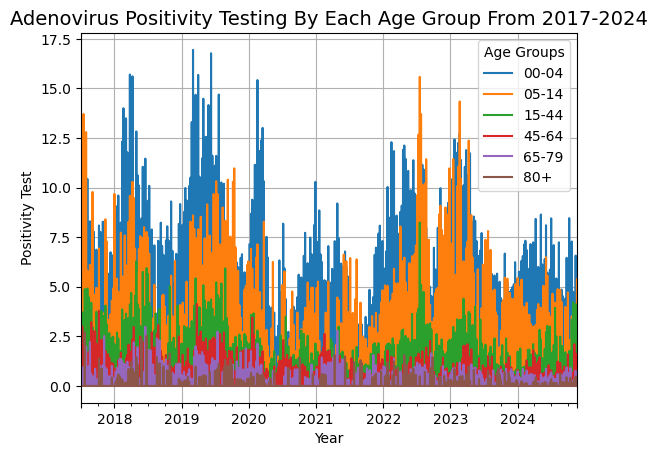

In [27]:
ax = timeseriesdf.plot()
ax.set_title("Adenovirus Positivity Testing By Each Age Group From 2017-2024", fontsize=14)
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Positivity Test", fontsize=10)
ax.grid(True)
plt.legend(title="Age Groups", fontsize=10)
plt.show()

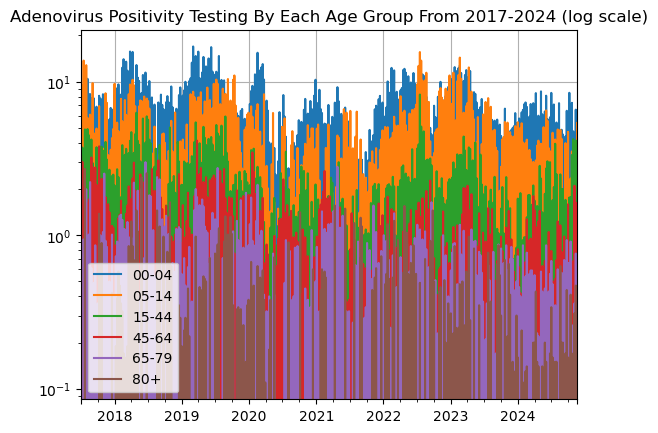

In [28]:
ax=timeseriesdf.plot(logy=True) # ...lemon squeezy
ax.grid(True)
ax.set_title('Adenovirus Positivity Testing By Each Age Group From 2017-2024 (log scale)');

In [29]:
# with open("lineage.json", "rt") as INFILE:
#     lineage=json.load(INFILE)

In [30]:
# lineage[:5]

In [31]:
# W-MON is "weekly on Mondays"
index=pd.date_range(startdate, enddate, freq='W-MON')
columns=['00-04', '05-14', '15-44', '45-64', '65-79', '80+']
lineagedf=pd.DataFrame(index=index, columns=columns)
lineagedf

,00-04,05-14,15-44,45-64,65-79,80+
2017-07-03,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-10,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-17,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-24,NaN,NaN,NaN,NaN,NaN,NaN
2017-07-31,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-10-21,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-28,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-04,NaN,NaN,NaN,NaN,NaN,NaN
2024-11-11,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
for date, age_data in data.items(): # each entry is a dictionary with cases, admissions and deaths
    pd_date=parse_date(date) # convert to Pandas format
    for age_group, value in age_data.items(): 
        if age_group in columns:
            lineagedf.loc[pd_date, age_group]=value
lineagedf.fillna(0.0, inplace=True)
lineagedf = lineagedf.infer_objects(copy=False)
print(lineagedf)


            00-04  05-14  15-44  45-64  65-79   80+
2017-07-03   7.66   9.18   3.60   3.24   2.31  0.00
2017-07-10   9.33   9.45   3.72   3.00   0.00  0.00
2017-07-17   8.73  13.71   3.17   2.05   0.94  0.00
2017-07-24  10.13   5.77   4.88   2.08   0.00  2.70
2017-07-31  10.12  12.80   3.70   1.06   1.99  0.00
...           ...    ...    ...    ...    ...   ...
2024-10-21   7.28   3.51   3.33   0.52   0.13  0.00
2024-10-28   4.75   2.67   4.23   0.68   0.26  0.17
2024-11-04   4.36   3.60   2.71   2.10   0.36  0.31
2024-11-11   6.57   2.52   4.13   1.63   0.76  0.47
2024-11-18   6.17   5.38   2.01   1.53   0.47  0.00

[386 rows x 6 columns]


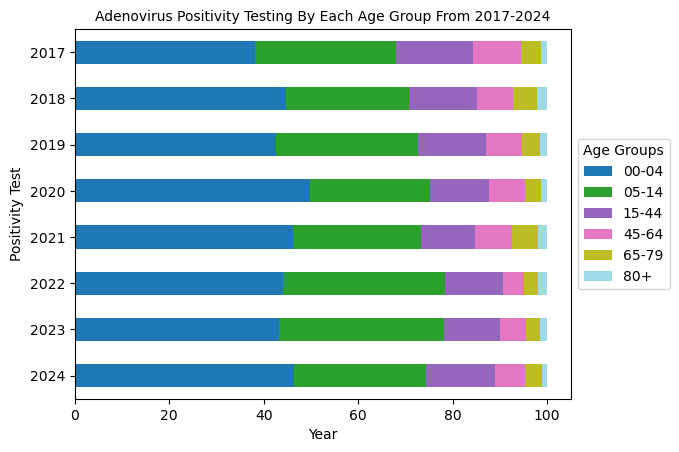

In [43]:
# Group by year using the updated '1YE' frequency
annually = lineagedf.groupby(pd.Grouper(freq='1YE')).mean()
totals = annually.sum(axis=1)  
annually = annually.div(totals, axis=0) * 100  

# Reverse the rows for the graph
annually = annually[::-1]

# Create a horizontal stacked bar plot
ax = annually.plot(kind='barh', stacked=True, cmap='tab20')

# Format the date nicely
ax.set_yticklabels(annually.index.strftime('%Y'))  # Annual format for years

# Set the title
ax.set_xlabel("Year", fontsize=10)
ax.set_ylabel("Positivity Test", fontsize=10)
plt.legend(title="Age Groups", fontsize=10, loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title('Adenovirus Positivity Testing By Each Age Group From 2017-2024', fontsize=10);


In [34]:
# pandas makes saving to a pickle file dead easy:
timeseriesdf.to_pickle("timeseriesdf.pkl")
lineagedf.to_pickle("lineagedf.pkl")

In [35]:
from IPython.display import clear_output
import ipywidgets as wdg
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from tkinter import PhotoImage
from ipywidgets import interact, widgets as wdg

In [36]:
%matplotlib inline
# make figures larger
plt.rcParams['figure.dpi'] = 100

In [37]:
# our API access function. This will be called by the button when it is clicked
def access_api(button):
    """Callback function for the button click."""
    # Example: Placeholder code for polling the API
    print("Polling the API...")
    # Change the button icon and disable it after the operation
    apibutton.icon = "check"  # FontAwesome icon name
    apibutton.disabled = True

# see the doc for the parameters    
apibutton = wdg.Button(
    description="Update",
    disabled=False,
    button_style="info",  # 'success', 'info', 'warning', 'danger', or ''
    tooltip="Click here to acquire current virus data",
    icon="refresh",  # Use FontAwesome icon names directly
    )

# register the callback function with the button
apibutton.on_click(access_api)

# this is an iPython function that generalises print for Jupyter Notebooks; we use it to 
# display the widgets
display(apibutton)


Button(button_style='info', description='Update', icon='refresh', style=ButtonStyle(), tooltip='Click here to …

Select(description='Year', index=7, options=(2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024), rows=1, value=20…

Output()

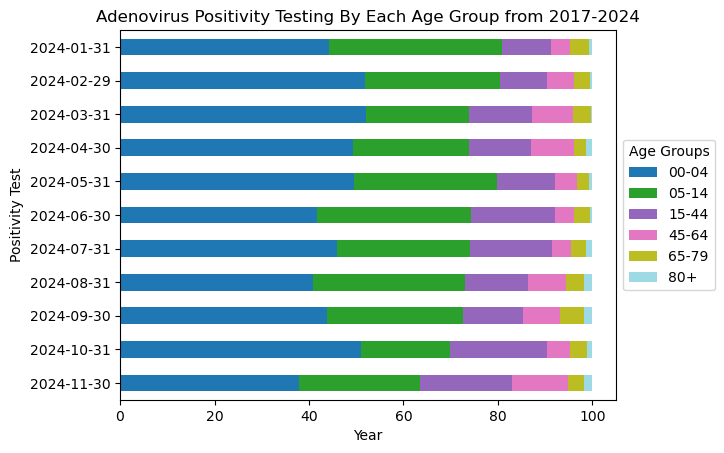

In [41]:
year=wdg.Select(
    # options available: unique years in the dataframe
    options=lineagedf.index.year.unique(), # options available
    value=lineagedf.index.year[-1], # initial value: most recent year
    rows=1, # rows of the selection box
    description='Year',
    disabled=False
)

def lineage_graph(graphyear):
    # our callback function.
    yeardf=lineagedf[lineagedf.index.year==graphyear]
    # average the rows by month
    monthly= yeardf.groupby(pd.Grouper(freq='ME')).mean() 
    totals=monthly.sum(axis=1) # over the rows
    # make sure it's all normalised to 100
    monthly=monthly.div(totals, axis=0)*100
    # older dates on top of the graph
    monthly = monthly[::-1]
    ax=monthly.plot(kind='barh', stacked=True,cmap='tab20')
    ax.legend(title="Age Groups", fontsize=10, loc='center left',bbox_to_anchor=(1.0, 0.5))
    ax.set_xlabel("Year", fontsize=10)
    ax.set_yticklabels(monthly.index.strftime('%Y-%m-%d'))
    ax.set_ylabel("Positivity Test", fontsize=10)
    ax.set_title('Adenovirus Positivity Testing By Each Age Group from 2017-2024');
    
# keep calling age_graph(graphcolumns=value_of_agecols); capture output in widget output    
output=wdg.interactive_output(lineage_graph, {'graphyear': year})

display(year, output)

In [39]:
# in the dashboard, this should be computed from the json files
timeseriesdf=pd.read_pickle("timeseriesdf.pkl")

In [40]:
def plot_adeno(age_group='00-04', scale='linear'):
    """
    Plots a scatter graph for the selected age group with y-axis scale option.
    
    Parameters:
    - age_group: The age group column to plot.
    - scale: The scale of the y-axis ('linear' or 'log').
    """
    if age_group in timeseriesdf.columns:
        x = timeseriesdf.index
        y = timeseriesdf[age_group].values
        plt.figure(figsize=(12, 6))
        plt.scatter(x, y, alpha=0.7, c='blue')
        plt.title(f"Adenovirus Positivity for Age Group {age_group} from 2017-2024", fontsize=14)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Metric Value", fontsize=12)
        plt.yscale(scale)  # Set y-axis scale (linear or log)
        plt.grid(True)
        plt.show()
    else:
        print(f"Invalid age group: {age_group}")

# Interactive widget
interact(
    plot_adeno,
    age_group=wdg.Dropdown(options=columns, description='Age Group'),
    scale=wdg.RadioButtons(options=['linear', 'log'], description='Y-axis Scale')
);

interactive(children=(Dropdown(description='Age Group', options=('00-04', '05-14', '15-44', '45-64', '65-79', …